In [ ]:
!pip install transformers
import os
from zipfile import ZipFile
from tqdm.notebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 69.8 MB/s 
     |████████████████████████████████| 7.6 MB 55.4 MB/s 


In [ ]:
import pandas as pd
import os

dataDir = '../data'
train = pd.read_csv(os.path.join(dataDir, 'train.csv'))

val = pd.read_csv(os.path.join(dataDir, 'val.csv'))
testA = pd.read_csv(os.path.join(dataDir, 'testA.csv'))
testB = pd.read_csv(os.path.join(dataDir, 'testB.csv'))
len(train), len(testA), len(testB)

(2110, 1249, 707)

In [ ]:
possible_labels = testA.Stance.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 0, 1: 1, 2: 2}

In [ ]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', 
                                          do_lower_case=True)
max_length = 320
encoded_data_train = tokenizer.batch_encode_plus(
    train.Query.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_length, 
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val.Query.values, 
    add_special_tokens=True, 
    return_attention_mask=True,  
    padding='max_length',
    max_length=max_length, 
    truncation=True,
    return_tensors='pt'
)

encoded_data_test_A = tokenizer.batch_encode_plus(
    testA.Query.values, 
    add_special_tokens=True, 
    return_attention_mask=True,  
    padding='max_length',
    max_length=max_length, 
    truncation=True,
    return_tensors='pt'
)

encoded_data_test_B = tokenizer.batch_encode_plus(
    testB.Query.values, 
    add_special_tokens=True, 
    return_attention_mask=True,  
    padding='max_length',
    max_length=max_length, 
    truncation=True,
    return_tensors='pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train.Stance.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val.Stance.values)

input_ids_test_A = encoded_data_test_A['input_ids']
attention_masks_test_A = encoded_data_test_A['attention_mask']
labels_test_A = torch.tensor(testA.Stance.values)


input_ids_test_B = encoded_data_test_B['input_ids']
attention_masks_test_B = encoded_data_test_B['attention_mask']
labels_test_B = torch.tensor(testB.Stance.values)


print(input_ids_train.shape, attention_masks_train.shape, labels_train.shape)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test_A = TensorDataset(input_ids_test_A, attention_masks_test_A, labels_test_A)
dataset_test_B = TensorDataset(input_ids_test_B, attention_masks_test_B, labels_test_B)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

torch.Size([2110, 320]) torch.Size([2110, 320]) torch.Size([2110])


In [ ]:
import torch
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 20

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test_A = DataLoader(dataset_test_A, 
                                   sampler=SequentialSampler(dataset_test_A), 
                                   batch_size=batch_size)

dataloader_test_B = DataLoader(dataset_test_B, 
                                   sampler=SequentialSampler(dataset_test_B), 
                                   batch_size=batch_size)

In [ ]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import json
from sklearn.metrics import f1_score

def f1_score_macro(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

        
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, preds_flat, average='weighted')

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('../models/BERTStance')
model.to(device)
z = 1

In [ ]:

print('BERTStance')

test_loss_A, predictions, true_vals = evaluate(dataloader_test_A)
test_f1_A = f1_score_func(predictions, true_vals)
test_f1_A_macro = f1_score_macro(predictions, true_vals)
pred_vals = [np.argmax(pred) for pred in predictions]
test_acc_A = accuracy_score(pred_vals, true_vals)

print(f'Test loss A: {test_loss_A}')
print(f'F1 Score (Weighted) A: {test_f1_A}')
print(f'F1 Score (Macro) A: {test_f1_A_macro}')
print(f'Test accuracy A: {test_acc_A}')
print('\n')

test_loss_B, predictions, true_vals = evaluate(dataloader_test_B)
test_f1_B = f1_score_func(predictions, true_vals)
test_f1_B_macro = f1_score_macro(predictions, true_vals)
pred_vals = [np.argmax(pred) for pred in predictions]
test_acc_B = accuracy_score(pred_vals, true_vals)

print(f'Test loss B: {test_loss_B}')
print(f'F1 Score (Weighted) B: {test_f1_B}')
print(f'F1 Score (Macro) B: {test_f1_B_macro}')
print(f'Test accuracy B: {test_acc_B}')
print('\n')

In [ ]:
pos_true_vals = []
neg_true_vals = []
neu_true_vals = []
pos_pred_vals = []
neg_pred_vals = []
neu_pred_vals = []

for i, val in enumerate(pred_vals):
    if val == 0:
        neg_pred_vals.append(0)
    else:
        neg_pred_vals.append(1)
        
    if val == 1:
        pos_pred_vals.append(0)
    else:
        pos_pred_vals.append(1)
        
    if val == 2:
        neu_pred_vals.append(0)
    else:
        neu_pred_vals.append(1)

for val in true_vals:
    if val == 0:
        neg_true_vals.append(0)
    else:
        neg_true_vals.append(1)
        
    if val == 1:
        pos_true_vals.append(0)
    else:
        pos_true_vals.append(1)
        
    if val == 2:
        neu_true_vals.append(0)
    else:
        neu_true_vals.append(1)

rocAucScore -  0.7775306321358953
[0.         0.25657895 1.        ] [0.         0.81164021 1.        ]


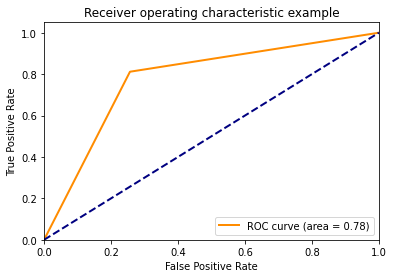

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
rocAucScore = roc_auc_score(pos_true_vals, pos_pred_vals)
fpr, tpr, _ = roc_curve(pos_true_vals, pos_pred_vals)
roc_auc = auc(fpr, tpr)
print('rocAucScore - ', rocAucScore)
print(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

rocAucScore -  0.7204015086037558
[0.         0.28391608 1.        ] [0.        0.7247191 1.       ]


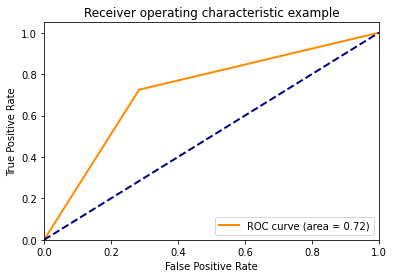

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
rocAucScore = roc_auc_score(neg_true_vals, neg_pred_vals)
fpr, tpr, _ = roc_curve(neg_true_vals, neg_pred_vals)
roc_auc = auc(fpr, tpr)
print('rocAucScore - ', rocAucScore)
print(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

rocAucScore -  0.7258202841660623
[0.        0.4826087 1.       ] [0.         0.93424926 1.        ]


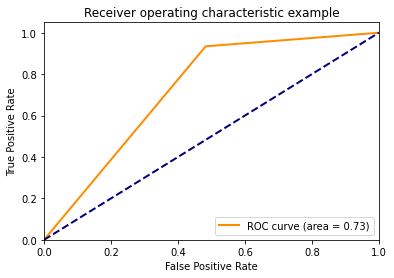

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
rocAucScore = roc_auc_score(neu_true_vals, neu_pred_vals)
fpr, tpr, _ = roc_curve(neu_true_vals, neu_pred_vals)
roc_auc = auc(fpr, tpr)
print('rocAucScore - ', rocAucScore)
print(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()